# Chapter 11: Quantum Linear Algebra

Hadamard tests, swap tests, and measurement overhead analysis.

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions


In [2]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate, QFTGate
from qiskit.circuit.library import QFT, phase_estimation, HamiltonianGate
from qiskit.quantum_info import SparsePauliOp
from Chapter03_EngineeringOptimization_functions import PlaneStressCantilever
from qiskit.circuit.library import  StatePreparation,DiagonalGate, ZGate, XGate
from Chapter03_EngineeringOptimization_functions import (truss2x2,truss3x2,truss2x3,truss3x3,truss_10bar,
                                                         PlaneStressCantilever)
from Chapter08_QuantumGates_functions import simulate_statevector, simulate_measurements #type: ignore

from Chapter11_QLA_functions import (LCU_Ax)



## Encoding a vector

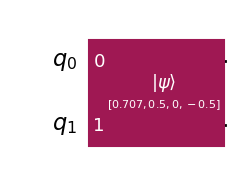

In [3]:
x = np.array([np.sqrt(2), 1, 0,-1])
n = int(np.ceil(np.log2(len(x))))
# Normalize the vector 
x = x / np.linalg.norm(x)

# Create circuit and prepare state
qc = QuantumCircuit(n)
qc.initialize(x, range(n))
display(qc.draw('mpl'))

## PREP-SELECT-UNPREP A*x for 2x2 matrix 

LCU Result:  [ 2.  -0.1]
Classical:   [ 2.  -0.1]


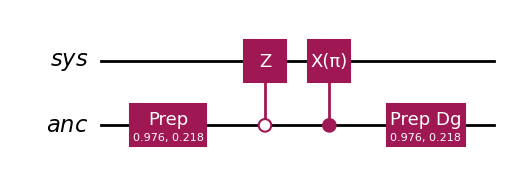

In [4]:
# 1. Define A and |x>
# A = 2Z - 0.1X
A = np.array([
    [2, -0.1],
    [-0.1, -2]
], dtype=float)

x = np.array([1, 0], dtype=complex)  # |0> state
expected_output = A @ x

# 2. Hardcoded decomposition: A = 2*Z + (-0.1)*X
c0, c1 = 2.0, -0.1
alpha = np.abs(c0) + np.abs(c1)  # 2.1

num_ancilla = 1
num_system = 1

qr_sys = QuantumRegister(num_system, 'sys')
qr_anc = QuantumRegister(num_ancilla, 'anc')
qc = QuantumCircuit(qr_sys, qr_anc)  # System on top, ancilla on bottom

# 3. PREP: Encode sqrt(|c0|/alpha), sqrt(|c1|/alpha)
prep_vec = np.array([np.sqrt(np.abs(c0)/alpha), np.sqrt(np.abs(c1)/alpha)])
prep_gate = StatePreparation(prep_vec, label='Prep')
qc.append(prep_gate, qr_anc)


# 4. SELECT: Apply controlled unitaries

# Term 0: Controlled-Z when ancilla = |0⟩, coefficient c0 = 2.0
phase0 = np.angle(c0)  # 0
gate_circ_0 = QuantumCircuit(num_system, global_phase=phase0)
gate_circ_0.append(ZGate(), [0])
ctrl_z = gate_circ_0.to_gate(label='Z').control(
    num_ctrl_qubits=num_ancilla,
    ctrl_state='0'
)
qc.append(ctrl_z, [qr_anc[0], qr_sys[0]])


# Term 1: Controlled-X when ancilla = |1⟩, coefficient c1 = -0.1
phase1 = np.angle(c1)  # π
gate_circ_1 = QuantumCircuit(num_system, global_phase=phase1)
gate_circ_1.append(XGate(), [0])
ctrl_x = gate_circ_1.to_gate(label='X(π)').control(
    num_ctrl_qubits=num_ancilla,
    ctrl_state='1'
)
qc.append(ctrl_x, [qr_anc[0], qr_sys[0]])

# 5. UNPREP
qc.append(prep_gate.inverse(), qr_anc)

# 6. Simulate and post-select
full_init = Statevector.from_label('0' * num_ancilla).expand(Statevector(x))
final_sv = full_init.evolve(qc)

# Post-selection: ancilla = |0⟩
stride = 2**num_ancilla

res_vector = final_sv.data[0:2**num_system] * alpha
print("="*50)
print("LCU Result: ", np.round(np.real_if_close(res_vector), 4))
print("Classical:  ", np.round(np.real_if_close(expected_output), 4))
print("="*50)

qc.draw('mpl')

## Pauli Expansion

In [5]:
A = np.array([
    [1, 0, 0, 0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0.5, 0, 0, 1]
])
pauliSplit = SparsePauliOp.from_operator(A)
print(pauliSplit.paulis)
print(pauliSplit.coeffs)

['II', 'XX', 'YY']
[ 1.  +0.j  0.25+0.j -0.25+0.j]


## Performing Ax using LCU_Ax

{'alpha': np.float64(1.5), 'num_system': 2, 'num_ancilla': 2, 'coeffs': array([ 1.  +0.j,  0.25+0.j, -0.25+0.j]), 'pauli_split': SparsePauliOp(['II', 'XX', 'YY'],
              coeffs=[ 1.  +0.j,  0.25+0.j, -0.25+0.j])}
Expected output: [0.6 0.8 0.  0.3]
Quantum output: [0.6 0.8 0.  0.3]
Success probability: 0.4844


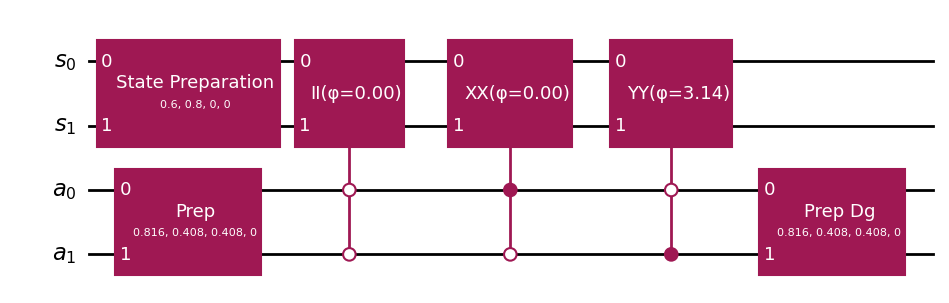

In [6]:
A = np.array([
    [1, 0, 0, 0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0.5, 0, 0, 1]
], dtype=float)

x = np.array([0.6, 0.8, 0, 0], dtype=complex)

expected_output = A @ x
# Create circuit
qc, metadata = LCU_Ax(A, x)
print(metadata)
# Get the exact statevector
final_state = Statevector(qc)
num_system = metadata['num_system']
alpha = metadata['alpha']


res_vector = final_state.data[:2**num_system] * alpha
success_prob = np.linalg.norm(final_state.data[:2**num_system])**2

print("Expected output:", np.round(np.real_if_close(expected_output), 4))
print("Quantum output:", np.round(np.real_if_close(res_vector), 4))
print("Success probability:", np.round(success_prob, 4))
qc.draw('mpl')

## LCU encoding of truss stiffness matrices

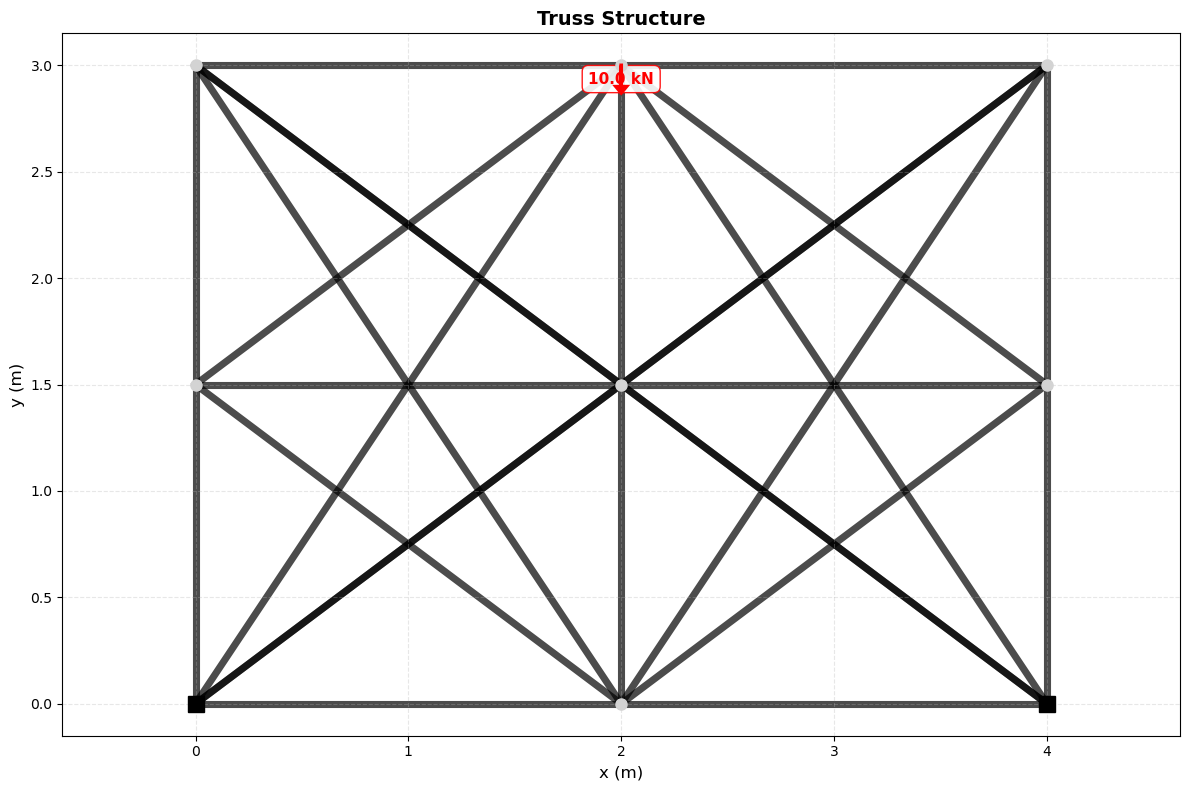

Size of K_full: (18, 18)
Size of K: (14, 14)
Size of sub-matrix A: (8, 8)
Number of Pauli terms: 24
Ancilla qubits needed: 5
System qubits needed: 3
Total qubits: 8
Normalization α: 4.3793e+08


In [7]:
fem_model= truss3x3()
fem_model.plot_truss()
K_full = fem_model.assemble_stiffness()
print("Size of K_full:", K_full.shape)
all_dofs = set(range(fem_model.n_dofs))
free_dofs = list(all_dofs - set(fem_model.fixed_dofs))
K = K_full[np.ix_(free_dofs, free_dofs)]
f = fem_model.loads[free_dofs]
print("Size of K:", K.shape)
N = 8
A = K[:N, :N]  # Just take a 4x4 block for testing
print("Size of sub-matrix A:", A.shape)
pauliSplit = SparsePauliOp.from_operator(A)
print("Number of Pauli terms:",pauliSplit.coeffs.shape[0])

# Resource requirements
num_ancilla = int(np.ceil(np.log2(pauliSplit.coeffs.shape[0])))  # One ancilla per Pauli term
num_system = int(np.ceil(np.log2(N)))
print(f"Ancilla qubits needed: {num_ancilla}")
print(f"System qubits needed: {num_system}")
print(f"Total qubits: {num_ancilla + num_system}")

# Normalization constant
alpha = np.sum(np.abs(pauliSplit.coeffs))
print(f"Normalization α: {alpha:.4e}")

## FEM Matrix Circuit analysis

In [8]:
# Create a simple test vector
x = np.zeros(8)
x[0] = 1.0  # Unit displacement at first DOF

# Create LCU circuit
qc, metadata = LCU_Ax(A, x, mode='statevector')

# Analyze circuit
print(f"Circuit depth: {qc.depth()}")
print(f"Number of qubits: {qc.num_qubits}")

# Decompose to basis gates
qc_decomposed = qc.decompose(reps=3)
print(f"\nAfter decomposition to basis gates:")
print(f"Circuit depth: {qc_decomposed.depth()}")
print(f"Total gates: {sum(qc_decomposed.count_ops().values())}")

Circuit depth: 26
Number of qubits: 8

After decomposition to basis gates:
Circuit depth: 1129
Total gates: 1775


## Block encoding

In [11]:
A = np.array([
    [1, 0, 0, 0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0.5, 0, 0, 1]
], dtype=float)
x = np.ones(A.shape[0])# dummy
x = x / np.linalg.norm(x)
qc, metadata = LCU_Ax(A, x, mode='statevector')
U_matrix = Operator(qc).data
alpha = metadata['alpha']
print("U shape:", U_matrix.shape)
print("alpha:", alpha)

U shape: (16, 16)
alpha: 1.5
